In [94]:
import os,sys,optparse,csv,resource

def setPedestalRun_v2(self,options):
    import pandas as pd
    import cygno as cy
        
    if not hasattr(options,"pedrun"):
        run = int(options.run)
    if options.offline==False:
        df = cy.read_cygno_logbook(tag=options.tag,start_run=run-2000,end_run=run+1)
    else:
        runlog='runlog_%s_auto.csv' % (options.tag)
        df = pd.read_csv('pedestals/%s'%runlog)
               
        dffilter = ((df["number_of_events"] >= 100) & (df["pedestal_run"] == 1) & (df["run_number"] <= run) & (df["HV_STATE"] == 0))
        runkey = df.run_number[dffilter].values.tolist()
        comment = df.run_description[dffilter].values.tolist()
        nevents = df.number_of_events[dffilter].values.tolist()
        options.pedrun = int(runkey)
        if runkey:
            print("Will use pedestal run %05d which has comment: '%s' and n of events: '%d'" % (int(runkey),comment,int(nevents)))
        else:
            print("Didn't find the pedestal corresponding to run %d in pedestals/%s. Check the csv runlog dump!" % (options.run, runlog))
    setattr(options,'pedfile_fullres_name', 'pedestals/pedmap_run%s_rebin1.root' % (options.pedrun))       
    return runkey, nevents

r, n =setPedestalRun_v2(self,options)

NameError: name 'self' is not defined

In [1]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy
import time
import pandas as pd

def baseline(f):
    noise=f[0:400]
    return np.mean(noise), np.std(noise)

def attorno_al_min(f, m, s):
    
    for i in range(len(f)):
        if (f[i]<m-5*s):
            start=max(i-2,400)
            break
        i+=1 

    if (i==len(f)):
        start=0

    stop=len(f)
    for j in range(start+2,len(f)):
        if (f[j]>m-4*s):
            stop=min(j+2,len(f))
            break
            j+=1

    return f[start:stop], start, stop
    

def pmt(w_slow):
    m, s = baseline(w_slow)
    fbas, start , stop = attorno_al_min(w_slow, m, s)
    
    f = np.array(fbas)
    for k in range(len(f)):
        f[k]=m-f[k]  
    
    #print(f)    
               
    return (np.sum(f)/(25*5))


r=[]    
R=13384
t=1

while (R<13409):
    run=13383
    if (R==t*5+run):
        t+=1
        R+=1
        
    else:
        r.append(R)
        R+=1
    
print(r)
print(len(r))

[13384, 13385, 13386, 13387, 13389, 13390, 13391, 13392, 13394, 13395, 13396, 13397, 13399, 13400, 13401, 13402, 13404, 13405, 13406, 13407]
20


In [16]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy
import time
import pandas as pd

def baseline(f):
    noise=f[0:400]
    return np.mean(noise), np.std(noise)

def attorno_al_min(f, m, s):

    f<m-5*s
    
    if (len(indici)==0):
        return 0
    else:
        return f[indici]
    

def pmt(w_slow):
    m, s = baseline(w_slow)
    fbas = attorno_al_min(w_slow, m, s)
    
    f = m-fbas  
    
    print(f)    
               
    return (np.sum(f)/(25*5))


r=[]    
R=13384
t=1

while (R<13389):
    run=13383
    if (R==t*5+run):
        t+=1
        R+=1
        
    else:
        r.append(R)
        R+=1
    
print(r)
print(len(r))

[13384, 13385, 13386, 13387]
4


In [17]:
i0=[]
#i1=[]



    
verbose = False
outplot = True # fa i plot
#run     = 13414
path    = '/jupyter-workspace/ba-storage/cygno-data/' # disco di bari

for k in range(len(r)):
    mfile = cy.open_mid(run=r[k], path=path, cloud=False, tag='LNF', verbose=verbose)

# esempio lettura informazioni dall'odb  #######
    odb = cy.get_bor_odb(mfile)
    corrected  = odb.data['Configurations']['DRS4Correction']
    channels_offsets  = odb.data['Configurations']['DigitizerOffset']
    #header_environment = odb.data['Equipment']['Environment']['Settings']['Names Input']
# esempio di retrive di variabili nell'odb
    #dslow = pd.DataFrame(columns = header_environment)
########################


# lettura equipment nel file #######
   
    for event in mfile:
        if event.header.is_midas_internal_event():
            print("Saw a special event")
            continue

        bank_names = ", ".join(b.name for b in event.banks.values())
    
        for bank_name, bank in event.banks.items():
            
            if ('DGH0' in bank_name): # PMTs wavform 
                full_header= cy.daq_dgz_full2header(event.banks['DGH0'], verbose=verbose)
                w_fast, w_slow = cy.daq_dgz_full2array(event.banks['DIG0'], full_header, verbose=verbose, corrected=corrected, ch_offset=channels_offsets)
                
                if outplot:
                    i0.append(pmt(w_slow[0])) 
                    #i1.append(pmt(w_slow[1]))
                          
        if event.header.serial_number == 250: # si ferma dopo i primi tot eventi
            break

    print("termine run",r[k])
    k+=1
        
print("fatto")

Saw a special event


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

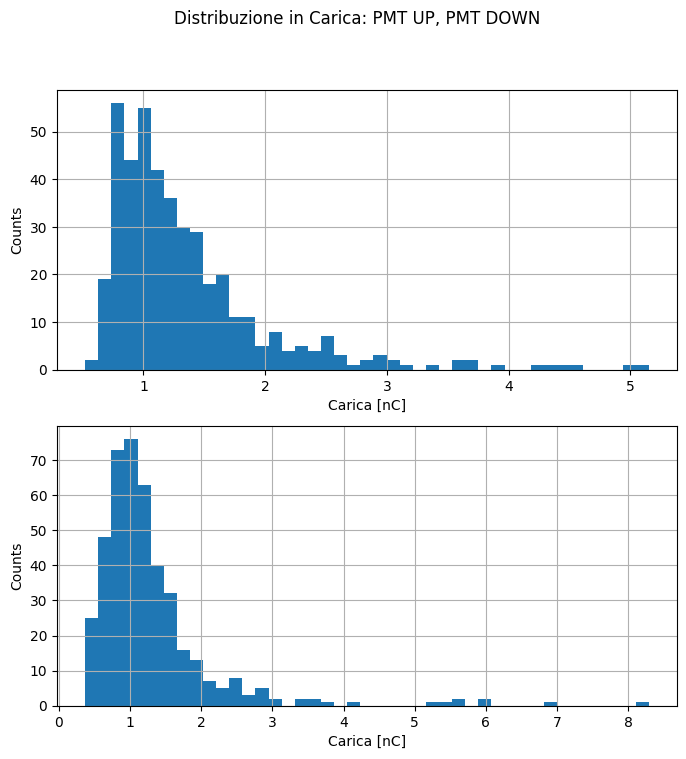

In [33]:
#più run: <5sigma >4sigma (+-5)

fig,ax=plt.subplots(2,figsize=(8,8))

fig.suptitle("Distribuzione in Carica: PMT UP, PMT DOWN")
for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel("Carica [nC]")
    ax[i].set_ylabel("Counts")
    
ax[0].hist(i0,bins=43)
ax[1].hist(i1,bins=43)

plt.show()

In [37]:
#20 run

i0=[]
i1=[]



    
verbose = False
outplot = True # fa i plot
#run     = 13414
path    = '/jupyter-workspace/ba-storage/cygno-data/' # disco di bari

for k in range(len(r)):
    mfile = cy.open_mid(run=r[k], path=path, cloud=False, tag='LNF', verbose=verbose)

# esempio lettura informazioni dall'odb  #######
    odb = cy.get_bor_odb(mfile)
    corrected  = odb.data['Configurations']['DRS4Correction']
    channels_offsets  = odb.data['Configurations']['DigitizerOffset']
    #header_environment = odb.data['Equipment']['Environment']['Settings']['Names Input']
# esempio di retrive di variabili nell'odb
    #dslow = pd.DataFrame(columns = header_environment)
########################


# lettura equipment nel file #######
   
    for event in mfile:
        if event.header.is_midas_internal_event():
            print("Saw a special event")
            continue

        bank_names = ", ".join(b.name for b in event.banks.values())
    
        for bank_name, bank in event.banks.items():
            
            if ('DGH0' in bank_name): # PMTs wavform 
                full_header= cy.daq_dgz_full2header(event.banks['DGH0'], verbose=verbose)
                w_fast, w_slow = cy.daq_dgz_full2array(event.banks['DIG0'], full_header, verbose=verbose, corrected=corrected, ch_offset=channels_offsets)
                
                if outplot:
                    i0.append(pmt(w_slow[0])) 
                    i1.append(pmt(w_slow[1]))
                          
        if event.header.serial_number == 250: # si ferma dopo i primi tot eventi
            break

    print("termine run",r[k])
    k+=1
        
print("fatto")

Saw a special event
termine run 13384
Saw a special event
termine run 13385
Saw a special event
termine run 13386
Saw a special event
termine run 13387
Saw a special event
termine run 13389
Saw a special event
termine run 13390
Saw a special event
termine run 13391
Saw a special event
termine run 13392
Saw a special event
termine run 13394
Saw a special event
termine run 13395
Saw a special event
termine run 13396
Saw a special event
termine run 13397
Saw a special event
termine run 13399
Saw a special event
termine run 13400
Saw a special event
termine run 13401
Saw a special event
termine run 13402
Saw a special event
termine run 13404
Saw a special event
termine run 13405
Saw a special event
termine run 13406
Saw a special event
termine run 13407
fatto


1599


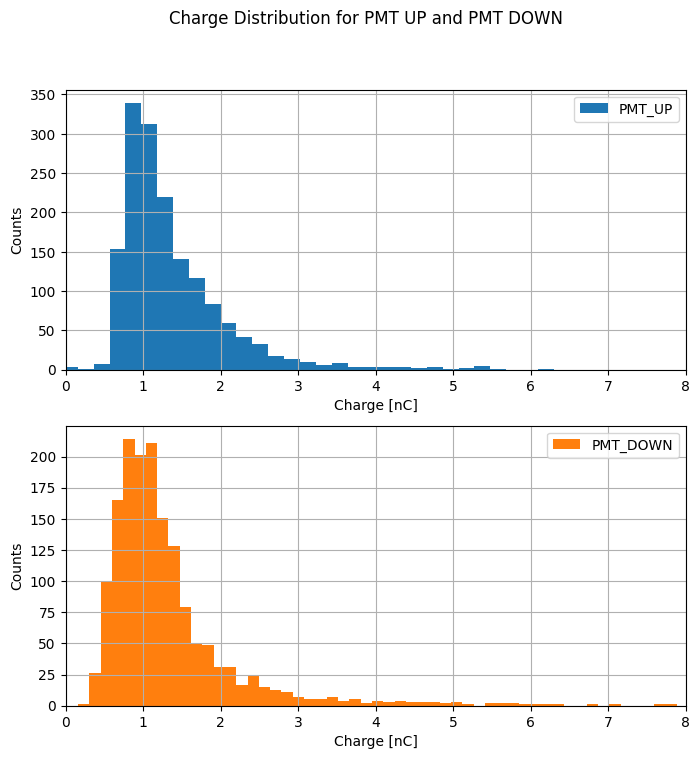

In [56]:
#20 run: <5sigma >4sigma (+-5)
print(len(i0))

fig,ax=plt.subplots(2,figsize=(8,8))

fig.suptitle("Charge Distribution for PMT UP and PMT DOWN")
for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel("Charge [nC]")
    ax[i].set_ylabel("Counts")
    ax[i].set_xlim(0,8)
    
ax[0].hist(i0,bins=100,color="tab:blue",label="PMT_UP")
ax[1].hist(i1,bins=100,color="tab:orange",label="PMT_DOWN")
ax[0].legend()
ax[1].legend()
plt.show()

In [4]:
#una run

i0=[]
i1=[]

verbose = False
outplot = True # fa i plot
run     = 13384
path    = '/jupyter-workspace/ba-storage/cygno-data/' # disco di bari

mfile = cy.open_mid(run=run, path=path, cloud=False, tag='LNF', verbose=verbose)

# esempio lettura informazioni dall'odb  #######
odb = cy.get_bor_odb(mfile)
corrected  = odb.data['Configurations']['DRS4Correction']
channels_offsets  = odb.data['Configurations']['DigitizerOffset']
header_environment = odb.data['Equipment']['Environment']['Settings']['Names Input']
# esempio di retrive di variabili nell'odb
dslow = pd.DataFrame(columns = header_environment)
########################


# lettura equipment nel file #######
   
#for event in mfile:
#    if event.header.is_midas_internal_event():
#        print("Saw a special event")
#        continue

#    bank_names = ", ".join(b.name for b in event.banks.values())
    
#    for bank_name, bank in event.banks.items():
#         if ('DGH0' in bank_name): # PMTs wavform 
#                full_header= cy.daq_dgz_full2header(event.banks['DGH0'], verbose=verbose)
#                w_fast, w_slow = cy.daq_dgz_full2array(event.banks['DIG0'], full_header, verbose=verbose, corrected=corrected, ch_offset=channels_offsets)
                
#                if outplot:
                    #i0.append(pmt(w_slow[0])) 
                    #i1.append(pmt(w_slow[1]))
                          
#    if event.header.serial_number == 250: # si ferma dopo i primi tot eventi
#        break

        
print(event.header.serial_number)

NameError: name 'event' is not defined

In [26]:
print(len(i0))

430


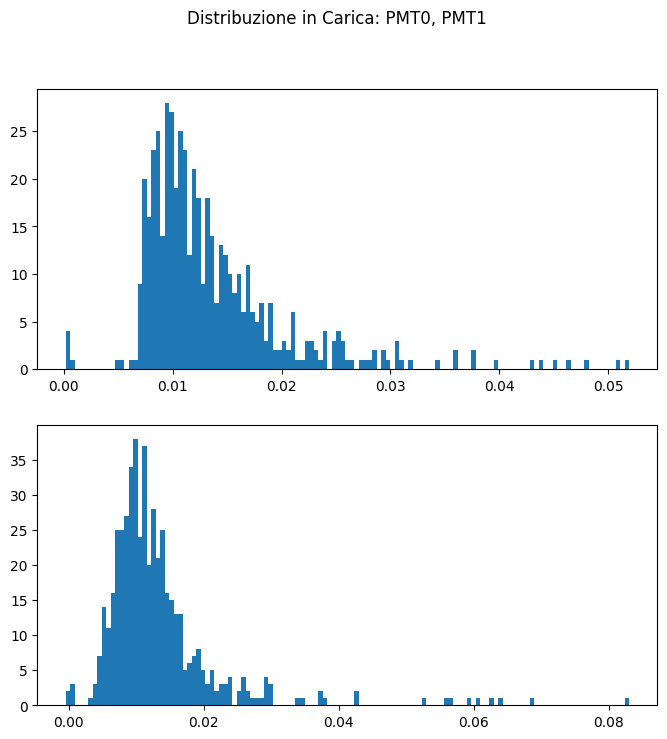

In [8]:
#una run: <5sigma >4sigma (+-5)
fig,ax=plt.subplots(2,figsize=(8,8))

fig.suptitle("Distribuzione in Carica: PMT0, PMT1")
#for i in range(4):
    #ax[i].set_xlim(0,650)
ax[0].hist(i0,bins=125)
ax[1].hist(i1,bins=125)

plt.show()

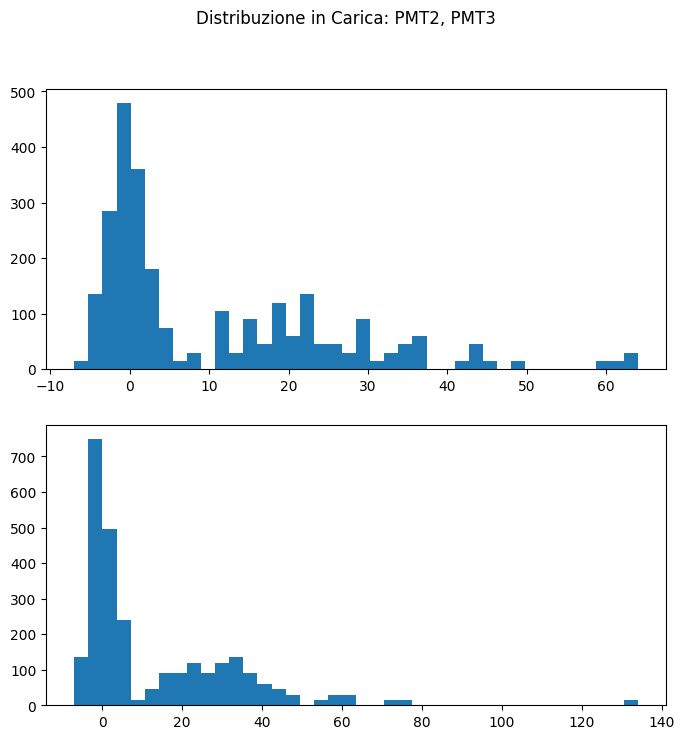

In [30]:
Saw#più run per PMT2,PMT3: <5sigma >4sigma, (+-5)

fig,ax=plt.subplots(2,figsize=(8,8))

fig.suptitle("Distribuzione in Carica: PMT2, PMT3")
#for i in range(2):
    #ax[i].set_xlim(0,10)
    #ax[i].set_ylim(0,600)
    
ax[0].hist(i2,bins=40)
ax[1].hist(i3,bins=40)

plt.show()